Вычисляем яркость...


Class 2: 100%|██████████| 566/566 [00:01<00:00, 368.88it/s]


2-й перцентиль яркости: 42.94
98-й перцентиль яркости: 141.36
Фильтруем изображения...


100%|██████████| 28100/28100 [00:38<00:00, 726.40it/s] 


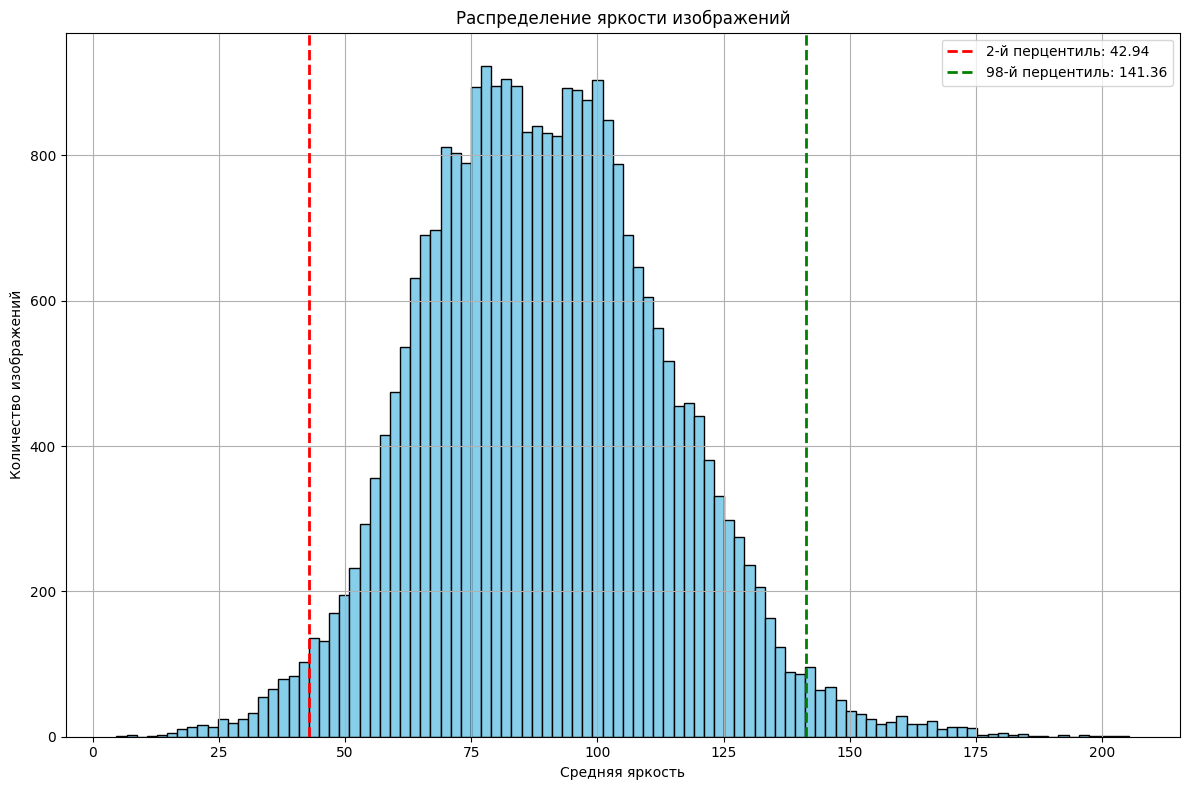

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# Параметры путей
input_dir = Path(r"D:/dataset/_eyepacs/data/ochishenii_fon_512_split/train")
output_base = Path(r"D:/dataset/_eyepacs/data/ochisheni_no_yarkosti")
train_output_dir = output_base / "train"
trash_dir = output_base / "trash"

# Подготовка
train_output_dir.mkdir(parents=True, exist_ok=True)
trash_dir.mkdir(parents=True, exist_ok=True)

# Шаг 1: Сбор яркостей
brightness_data = []

print("Вычисляем яркость...")
for class_folder in input_dir.iterdir():
    if not class_folder.is_dir():
        continue
    label = class_folder.name
    for image_path in tqdm(list(class_folder.glob("*.jpg")), desc=f"Class {label}"):
        try:
            img = Image.open(image_path).convert("L")  # grayscale
            arr = np.array(img)
            brightness = np.mean(arr)
            brightness_data.append({
                "image_path": image_path,
                "brightness": brightness,
                "label": label
            })
        except:
            print(f"Ошибка при обработке {image_path}")

df = pd.DataFrame(brightness_data)

# Шаг 2: Расчет перцентилей
p2 = np.percentile(df["brightness"], 2)
p98 = np.percentile(df["brightness"], 98)
print(f"2-й перцентиль яркости: {p2:.2f}")
print(f"98-й перцентиль яркости: {p98:.2f}")

# Шаг 3: Фильтрация
print("Фильтруем изображения...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    brightness = row["brightness"]
    src_path = row["image_path"]
    label = row["label"]
    if p2 <= brightness <= p98:
        target_path = train_output_dir / label
        target_path.mkdir(parents=True, exist_ok=True)
        shutil.copy(src_path, target_path / src_path.name)
    else:
        shutil.copy(src_path, trash_dir / f"{label}_{src_path.name}")

# Шаг 4: Визуализация
plt.figure(figsize=(12, 8))
plt.hist(df["brightness"], bins=100, color='skyblue', edgecolor='black')
plt.axvline(p2, color='red', linestyle='--', linewidth=2, label=f'2-й перцентиль: {p2:.2f}')
plt.axvline(p98, color='green', linestyle='--', linewidth=2, label=f'98-й перцентиль: {p98:.2f}')
plt.xlabel("Средняя яркость")
plt.ylabel("Количество изображений")
plt.title("Распределение яркости изображений")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
